# スコア検定



## 概要

### スコア関数

分布$f(x|\theta)$からランダムに得られた$n$個のサンプルを$X = (X_1, \cdots, X_n)$とする。

$X$の同時確率関数（尤度）を$\prod_{i=1}^n f(x_i|\theta)$を$f_n(x|\theta)$と表す。

対数尤度$l(\theta, X) = \log f_n(X|\theta)$の導関数

$$
l'_n(\theta, X) = \frac{d}{d \theta} \log f_n(X|\theta)
$$

を **スコア関数** （score function）という。


### フィッシャー情報量

スコア関数の2乗の期待値

$$
I_n(\theta)=E\left[\left\{l'_n(\theta, \boldsymbol{X})\right\}^2\right]=E\left[\left\{\frac{d}{d \theta} \log f_n(\boldsymbol{X} \mid \theta)\right\}^2\right]
$$

を **フィッシャー情報量** という。



### スコア関数の性質

$$
E[l'_n(\theta, X)] = 0\\
Var[l'_n(\theta, X)] = -E[l''_n(\theta,X)]= I_n(\theta) = n I_1(\theta)
$$

（$I_1(\theta)$はサンプル1つのフィッシャー情報量）

となるので、中心極限定理により、$n$が真値のとき

$$
l'(\theta, \boldsymbol{X}) / \sqrt{n I_1(\theta)} \rightarrow_d \mathcal{N}(0,1)
$$

という漸近正規性があるので、これを使って検定ができる

:::{dropdown} TODO: 導出を追う
$l'_1(\theta, X_i) = \{(d/d\theta) f(x|\theta)\} / f(x|\theta)$と書けるらしいので（？）

$$
\begin{aligned}
E\left[l'_1\left(\theta, X_i\right)\right] & =\int\left\{\frac{(d / d \theta) f(x \mid \theta)}{f(x \mid \theta)}\right\} f(x \mid \theta) d x \\ & =\int \frac{d}{d \theta} f(x \mid \theta) d x=\frac{d}{d \theta} \int f(x \mid \theta) d x=\frac{d}{d \theta} 1=0
\end{aligned}
$$
:::

### スコア検定

$$
H_0: \theta = \theta_0
\quad \text{v.s.} \quad
H_1: \theta \neq \theta_0
$$

に対して、

$$
R=\left\{\boldsymbol{x} \in \mathcal{X} \mid | l'_n\left(\theta_0, \boldsymbol{x}\right) \mid / \sqrt{n I_1\left(\theta_0\right)} \geq z_{\alpha / 2}\right\}
$$

を棄却域とする検定を **スコア検定** （score test） という。


## 例

参考：Julia and real estate statistics

ガンマ分布っぽいデータがあったとする。

ガンマ分布のshapeパラメータ$\alpha$は、$\alpha=1$のとき指数分布と一致する。

データが指数分布（$\alpha=1$）に従っているのか、かガンマ分布（$\alpha \neq 1$）なのか検定する（ガンマ分布のscaleパラメータは既知とする）

最尤推定量$\alpha_{ML}$について以下の仮説に対する検定を行う

$$
H_0: \alpha_{ML} = 1
\quad \text{v.s.} \quad
H_1: \alpha_{ML} \neq 1
$$

以下のようなデータがあるとする

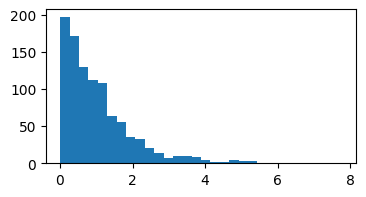

In [10]:
import numpy as np

np.random.seed(0)
n = 1000
alpha = 1.1  # 知りたいパラメータ
scale = 1    # 今回は既知とする
x = np.random.gamma(shape=alpha, scale=scale, size=n)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=[4,2])
ax.hist(x, bins=30)
fig.show()

最尤推定量$\alpha_{ML}$を求める

In [11]:
from scipy.stats import gamma

def log_likelihood(alpha):
    return np.sum(gamma.logpdf(x, a=alpha, scale=scale))

def neg_log_likelihood(alpha, scale, data):
    # scipyはminimize_scalar しかないので、対数尤度ではなく負の対数尤度にする
    return -np.sum(gamma.logpdf(data, a=alpha, scale=scale))

from scipy.optimize import minimize_scalar
result = minimize_scalar(neg_log_likelihood, args=(scale, x), bounds=(0.01, 10), method='bounded')
alpha_hat = result.x

# 最尤推定量
print(f"{alpha_hat=:.3f}")

alpha_hat=1.075



$E[-l''_n(\theta,X)]= I_n(\theta)$を使い、対数尤度の2階微分でフィッシャー情報量を求める


In [12]:
import numdifftools as nd
grad = nd.Derivative(log_likelihood, n=1)
hess = nd.Derivative(log_likelihood, n=2)
print(f"{grad(alpha_hat)=}, {hess(alpha_hat)=}")

grad(alpha_hat)=array(0.0002217), hess(alpha_hat)=array(-1480.84211289)


なぜフィッシャー情報量で割るのか → 対数尤度のピークが鋭ければ$l''(\theta)$は大きな値をとるためらしい

/usr/local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/usr/local/lib/python3.10/site-packages/numdifftools/limits.py:150: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


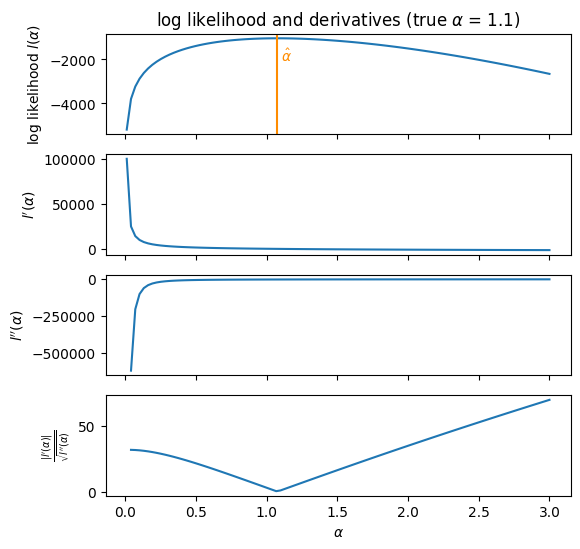

In [13]:
fig, axes = plt.subplots(figsize=[6, 6], nrows=4, sharex=True)

alphas = np.linspace(0.01, 3, 100)
axes[0].plot(alphas, [log_likelihood(a) for a in alphas])
axes[0].axvline(alpha_hat, color="darkorange")
axes[0].text(alpha_hat, log_likelihood(alpha_hat)*2, r" $\hat{\alpha}$", color="darkorange")
axes[0].set(ylabel=r"log likelihood $l(\alpha)$",
           title=fr"log likelihood and derivatives (true $\alpha$ = {alpha})")

scores = [grad(a).tolist() for a in alphas]
axes[1].plot(alphas, scores)
axes[1].set(ylabel=r"$l'(\alpha)$")

infos = [hess(a).tolist() for a in alphas]
axes[2].plot(alphas, infos)
axes[2].set(ylabel=r"$l''(\alpha)$")

test_stats = [(abs(score)/np.sqrt(-info)) for score, info in zip(scores, infos)]
axes[3].plot(alphas, test_stats)
axes[3].set(xlabel=r"$\alpha$", ylabel=r"$\frac{|l'(\alpha)|}{ \sqrt{l''(\alpha)}}$")

fig.show()

$\alpha = 1$とする（$\alpha_0=1$とする）という帰無仮説のもとでの検定統計量を計算

In [25]:
# 検定統計量
alpha_0 = 1

I = -hess(alpha_0)  # I = E[-l''(θ)]
score = abs(grad(alpha_0)) / np.sqrt(I)
print(f"|l'(α0)| / √I(α0) = {score:.3f}")

|l'(α0)| / √I(α0) = 2.894


これは標準正規分布上では次のような値になる

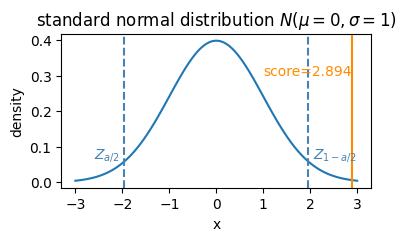

In [23]:
from scipy.stats import norm

fig, ax = plt.subplots(figsize=[4, 2])

# 検定統計量が従う標準正規分布
x_for_plot = np.linspace(-3, 3, 100)
z = norm.pdf(x_for_plot, loc=0, scale=1)
ax.plot(x_for_plot, z)
clevel = 0.05 / 2
for a in [clevel, (1 - clevel)]:
    ppf = norm.ppf(a)
    ax.axvline(x=ppf, color="steelblue", linestyle="--")
    if ppf < 0:
        ax.text(ppf - 0.1, norm.pdf(ppf) + 0.01, "$Z_{a/2}$", color="steelblue", horizontalalignment="right")
    else:
        ax.text(ppf + 0.1, norm.pdf(ppf) + 0.01, "$Z_{1-a/2}$", color="steelblue", horizontalalignment="left")
ax.set(xlabel="x", ylabel="density", title=f"standard normal distribution $N(\mu=0, \sigma=1)$")

# 検定統計量
ax.axvline(score, color="darkorange")
ax.text(score, 0.3, f"{score=:.3f}", color="darkorange", horizontalalignment="right")

fig.show()

In [16]:
from scipy.stats import norm

pvalue = 2 * (1 - norm.cdf(score))
pvalue

0.0038054754122531786